<a href="https://colab.research.google.com/github/pireylow/stock-price-prediction-LSTM-ARIMA/blob/main/LSTM_Optimise_n_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [ ]:
#set stock information
ticker = 'SPY'
startdate = '2018-01-01'
enddate = '2023-01-01'

start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)
sdata = pdr.get_data_yahoo(ticker, start=start, end=end)

columnsTitles=['Open','High','Low','Close','Volume','Adj Close']
sdata=sdata.reindex(columns=columnsTitles)

close=sdata['Close']
close.describe()

[*********************100%***********************]  1 of 1 completed


count    1259.000000
mean      344.338904
std        66.595683
min       222.949997
25%       283.980011
50%       326.859985
75%       402.525009
max       477.709991
Name: Close, dtype: float64

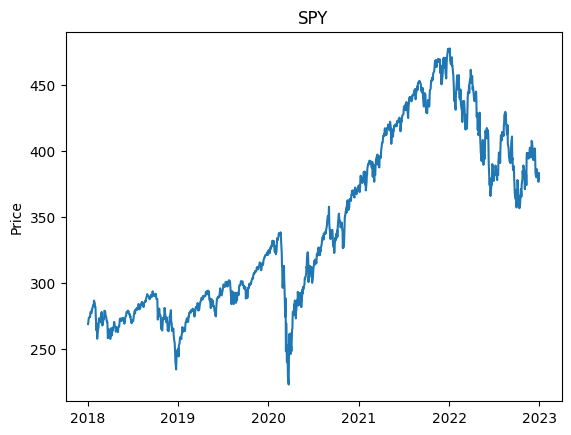

In [ ]:
#simple plot for double check of data
plt.title(ticker)
plt.plot(sdata['Close'])
plt.ylabel('Price')
plt.show()

In [ ]:
sdata

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,86655700,244.918671
2018-01-03,268.959991,270.640015,268.959991,270.470001,90070400,246.467804
2018-01-04,271.200012,272.160004,270.540009,271.609985,80636400,247.506622
2018-01-05,272.510010,273.559998,271.950012,273.420013,83524000,249.156036
2018-01-08,273.309998,274.100006,272.980011,273.920013,57319200,249.611664
...,...,...,...,...,...,...
2022-12-23,379.649994,383.059998,378.029999,382.910004,59857300,380.042480
2022-12-27,382.790009,383.149994,379.649994,381.399994,51638200,378.543793
2022-12-28,381.329987,383.390015,376.420013,376.660004,70911500,373.839264


In [ ]:
#create price data set
Y = sdata.iloc[:,3].values
final_dataset = Y.reshape(len(Y),1) #scaler needs two dimensions

ntrvals = 1200
train_data=final_dataset[0:ntrvals,:]
valid_data=final_dataset[ntrvals:,:]


In [ ]:
#scale the data set
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

"""
the above dataset with scaling is used below to run the optimization tests
"""


'\nthe above dataset with scaling is used below to run the optimization tests \n'

In [ ]:
#blocksize (LSTM timesteps) and n_units (LSTM units)
#blocksize_list = list(range(60,80,5))
#n_units_list = list(range(30,50,10))
#blocksize_list = list(range(30,100,10))
#n_units_list = list(range(30,120,10))
blocksize_list = list(range(30,130,10))
n_units_list = list(range(30,160,10))

#set up surf matrices
blocksize_list_length=len(blocksize_list)
n_units_list_length=len(n_units_list)
X = np.zeros((blocksize_list_length,n_units_list_length))
Y = np.zeros((blocksize_list_length,n_units_list_length))
Z = np.zeros((blocksize_list_length,n_units_list_length))

#number of features for LSTM
nfeatures = 5

#loop to train and test ....
blocksize_index=0
for blocksize in blocksize_list:

  n_units_index=0
  for n_units in n_units_list:

    #build the LSTM training set
    x_train_data,y_train_data=[],[]

    #set up
    for i in range(blocksize,len(train_data)-nfeatures+1):
      tmp = scaled_data[i-blocksize:i+nfeatures,0]
      xout = [ ]
      for j in range(len(tmp)-nfeatures):
        xout.append(tmp[j:j+nfeatures].tolist())
      x_train_data.append(xout)
      y_train_data.append(scaled_data[i+nfeatures-1,0])

    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

    #build the model
    lstm_model=Sequential()
    #lstm_model.add(LSTM(units=n_units,return_sequences=True,input_shape=(x_train_data.shape[1],nfeatures)))
    #lstm_model.add(LSTM(units=n_units,return_sequences=True,input_shape=(x_train_data.shape[1],nfeatures)))
    #lstm_model.add(LSTM(units=n_units))

    lstm_model.add(LSTM(units=n_units,input_shape=(x_train_data.shape[1],nfeatures)))
    lstm_model.add(Dense(15))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

    #test the model
    inputs_data=scaled_data[len(final_dataset)-len(valid_data)-blocksize :,:]

    X_test=[]
    Y_test=[]
    for i in range(blocksize,inputs_data.shape[0]-nfeatures+1):
      tmp = inputs_data[i-blocksize:i+nfeatures,0]
      xout = [ ]
      for j in range(len(tmp)-nfeatures):
        xout.append(tmp[j:j+nfeatures].tolist())
      X_test.append(xout)
      Y_test.append(inputs_data[i+nfeatures-1,0])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    Y_test=np.reshape(Y_test,(Y_test.shape[0],1))
    predicted_closing_price=lstm_model.predict(X_test)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

    if nfeatures == 1:
      mse =  (1/len(valid_data)) * np.sum((predicted_closing_price-valid_data)*(predicted_closing_price-valid_data))
    else:
      mse =  (1/len(valid_data[:-nfeatures+1])) * np.sum((predicted_closing_price-valid_data[:-nfeatures+1])*(predicted_closing_price-valid_data[:-nfeatures+1]))

    #update surf matrices
    X[blocksize_index,n_units_index] = blocksize
    Y[blocksize_index,n_units_index] = n_units
    Z[blocksize_index,n_units_index] = mse

    print(blocksize_index, n_units_index, blocksize, n_units)
    n_units_index+=1
  blocksize_index+=1




1166/1166 - 10s - loss: 0.0022 - 10s/epoch - 8ms/step
2/2 [==============================] - 1s 11ms/step
0 0 30 30
1166/1166 - 18s - loss: 0.0037 - 18s/epoch - 16ms/step
2/2 [==============================] - 1s 13ms/step
0 1 30 40
1166/1166 - 14s - loss: 0.0023 - 14s/epoch - 12ms/step
2/2 [==============================] - 0s 9ms/step
0 2 30 50
1166/1166 - 11s - loss: 0.0023 - 11s/epoch - 9ms/step
2/2 [==============================] - 0s 10ms/step
0 3 30 60
1166/1166 - 11s - loss: 0.0033 - 11s/epoch - 10ms/step


2/2 [==============================] - 0s 14ms/step
0 4 30 70
1166/1166 - 12s - loss: 0.0021 - 12s/epoch - 10ms/step


2/2 [==============================] - 0s 13ms/step
0 5 30 80
1166/1166 - 12s - loss: 0.0020 - 12s/epoch - 10ms/step
2/2 [==============================] - 1s 16ms/step
0 6 30 90
1166/1166 - 13s - loss: 0.0030 - 13s/epoch - 11ms/step
2/2 [==============================] - 0s 11ms/step
0 7 30 100
1166/1166 - 13s - loss: 0.0022 - 13s/epoch - 11ms/step
2/2 [==============================] - 1s 22ms/step
0 8 30 110
1166/1166 - 14s - loss: 0.0054 - 14s/epoch - 12ms/step
2/2 [==============================] - 0s 14ms/step
0 9 30 120
1166/1166 - 15s - loss: 0.0029 - 15s/epoch - 13ms/step
2/2 [==============================] - 1s 25ms/step
0 10 30 130
1166/1166 - 15s - loss: 0.0032 - 15s/epoch - 13ms/step
2/2 [==============================] - 1s 22ms/step
0 11 30 140
1166/1166 - 17s - loss: 0.0020 - 17s/epoch - 15ms/step
2/2 [==============================] - 0s 24ms/step
0 12 30 150
1156/1156 - 13s - loss: 0.0033 - 13s/epoch - 11ms/step
2/2 [==============================] - 0s 9ms/step
1 0 

In [ ]:
x_train_data.shape

(1076, 120, 5)

In [ ]:
X_test.shape

(55, 120, 5)


LSTM timesteps with Min MSE =  80
LSTM units with Min MSE =  30
Min MSE =  15.383232985182918


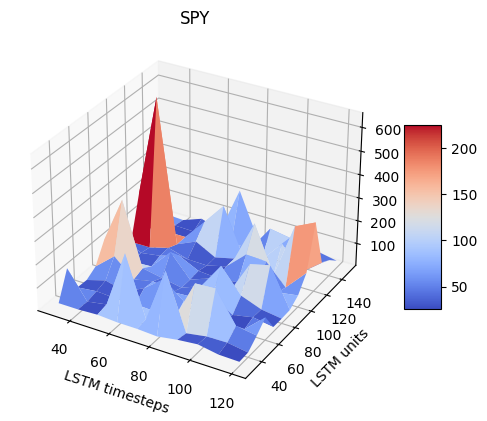

In [ ]:
#get min MSE and surf plaot
print()
minptr = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
print('LSTM timesteps with Min MSE = ', int(X[minptr]))
print('LSTM units with Min MSE = ', int(Y[minptr]))
print('Min MSE = ', Z[minptr])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(ticker)
ax.set_xlabel('LSTM timesteps')
ax.set_ylabel('LSTM units')
ax.set_zlabel('Prediction MSE')
plt.show()
